# A code to suggest cocktails based on ingredients

In [3]:
import requests
from bs4 import BeautifulSoup as bs
import csv
import time
import re
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

###### First, we get the recipes from www.drinksmixer.com . 

We get the receipes links first.

In [72]:
page_address = []
for i in range(1,9):
    page_address.append("http://www.drinksmixer.com/search/?q=cocktail&d=1&p=" + str(i))

list_1 = []

for i in range(8):   
    page = requests.get(page_address[i], time.sleep(.2))
    
    
#create beautiful soup object
    soup = bs(page.text, 'html.parser')


    for i in range(2):
        list_1.append(soup.find_all(class_= "l1a")[i].find_all("a"))

###flatten list_1
list_flat = [item for sublist in list_1 for item in sublist]


link_tails = []
for i in range(len(list_flat)):
        link_tails.append(list_flat[i]["href"])
        
        
### Now Build the recipe links ###

recipe_links = []
for i in range(len(link_tails)):
    recipe_links.append("http://www.drinksmixer.com" + link_tails[i]) 
    


In [73]:
recipe_links[0:10]

['http://www.drinksmixer.com/drink10391.html',
 'http://www.drinksmixer.com/drink7469.html',
 'http://www.drinksmixer.com/drink10313.html',
 'http://www.drinksmixer.com/drink8489.html',
 'http://www.drinksmixer.com/drink688.html',
 'http://www.drinksmixer.com/drink694.html',
 'http://www.drinksmixer.com/drink3411.html',
 'http://www.drinksmixer.com/drink740.html',
 'http://www.drinksmixer.com/drink746.html',
 'http://www.drinksmixer.com/drink750.html']

Now we get the recipes:

In [341]:
cocktail_rec = []
for link in recipe_links:
    
    page = requests.get(link, time.sleep(.5))

    soup = bs(page.text, 'html.parser')

    cocktail_name = soup.find(class_ = "fn recipe_title").string


    ing_name = soup.find(class_ = "ingredients").find_all(class_="name")
    ing_amount = soup.find(class_ = "ingredients").find_all(class_="amount")

    rating = soup.find(class_ = "ratingsBox rating").find("div",{"style":"font-size:36px; font-weight: bold;"})
    votes_num = soup.find(class_ = "ratingsBox rating").find("span",{"class":"count"})
    
    if rating != None:
        rating = rating.string
    if votes_num != None:
        votes_num = votes_num.string

    ingredients = [item.string for item in ing_name]

    cocktail_el = [cocktail_name, ingredients, rating, votes_num]
    cocktail_rec.append(cocktail_el)

cocktail_rec is now a nested list: [cocktail_name, [ingredients], rating, votes_num]

In [74]:
# total of 712 rec
len(cocktail_rec)

NameError: name 'cocktail_rec' is not defined

In [342]:
###  connect the words in ingredients,,, we don't want to match "juice"
###  with "juice", orange juice --> orangejuice
    
for j in range(len(cocktail_rec)):
    for i in range(len(cocktail_rec[j][1])):
        cocktail_rec[j][1][i] = cocktail_rec[j][1][i].replace(" ","")

In [343]:
for i in range(len(cocktail_rec)):
    rec=""
    for word in cocktail_rec[i][1]:
        rec = rec + word + " "
    cocktail_rec[i][1] = rec
    cocktail_rec[i][0] = cocktail_rec[i][0].replace(" Cocktail","").replace(" recipe", "")

In [345]:
# cocktail_rec

In [347]:
###  make a dataframe and save as cocktail_rec

receipe_df = pd.DataFrame(cocktail_rec , columns = ["Cocktail" , "Receipe", "Rating", "Number of Votes" ])

receipe_df.to_csv(r'E:\Saeed\Data Science\cocktail recipes\cocktail_rec.csv', index=False)

In [348]:
receipe_df.head()

,Cocktail,Receipe,Rating,Number of Votes
0,187,RedRum®rum 99Bananas®bananaschnapps strawberry...,7.8,47
1,209 East,Sauza®HornitosReposadotequila Cointreau®orange...,7.4,27
2,352,151proofrum GreyGoose®vodka WildTurkey®bourbon...,7.0,16
3,A1,gin GrandMarnier®orangeliqueur lemonjuice gren...,8.5,23
4,Abbey,gin orangebitters oranges cherry,9.0,21


### Now we look at some statistics

In [75]:
### read the receipe datafram
receipe_df = pd.read_csv('E:\Saeed\Data Science\cocktail recipes\cocktail_rec.csv')

In [77]:
receipe_df.head()

,Cocktail,Receipe,Rating,Number of Votes
0,187,RedRum®rum 99Bananas®bananaschnapps strawberry...,7.8,47.0
1,209 East,Sauza®HornitosReposadotequila Cointreau®orange...,7.4,27.0
2,352,151proofrum GreyGoose®vodka WildTurkey®bourbon...,7.0,16.0
3,A1,gin GrandMarnier®orangeliqueur lemonjuice gren...,8.5,23.0
4,Abbey,gin orangebitters oranges cherry,9.0,21.0


In [78]:
## missing element ?
receipe_df.isnull().sum()

Cocktail             0
Receipe              0
Rating             136
Number of Votes    136
dtype: int64

In [79]:
## build a series of number of ingredients and add to receipe_df
receipe_df['Number of Ingredients']  = receipe_df['Receipe'].apply(lambda st : len(st.split()))

In [80]:
receipe_df.head()

,Cocktail,Receipe,Rating,Number of Votes,Number of Ingredients
0,187,RedRum®rum 99Bananas®bananaschnapps strawberry...,7.8,47.0,9
1,209 East,Sauza®HornitosReposadotequila Cointreau®orange...,7.4,27.0,4
2,352,151proofrum GreyGoose®vodka WildTurkey®bourbon...,7.0,16.0,3
3,A1,gin GrandMarnier®orangeliqueur lemonjuice gren...,8.5,23.0,4
4,Abbey,gin orangebitters oranges cherry,9.0,21.0,4


In [81]:
sorted(receipe_df['Number of Ingredients'].unique())

[2, 3, 4, 5, 6, 7, 8, 9]

In [82]:
# build a new data frame by removing None values for rate 
receipe_df_rate = receipe_df.dropna()

In [83]:
receipe_df_rate.isnull().sum()

Cocktail                 0
Receipe                  0
Rating                   0
Number of Votes          0
Number of Ingredients    0
dtype: int64

In [84]:
#look at the rating distribution, (first build a dict to count # of each rating)
rating_dict = {}
for rating in set(receipe_df_rate["Rating"]):
    num_of_rating = list(receipe_df_rate["Rating"]).count(rating)
    rating_dict[rating] = num_of_rating

rating_list = sorted(rating_dict.items(), key=lambda x:x[0])

In [25]:
# rating_list

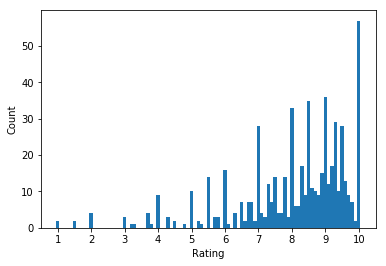

In [85]:
import matplotlib.pyplot as plt

# rating distribution
num_of_rating = [count for rating,count in rating_list]
rating = [rating for rating,count in rating_list]

plt.bar(rating, num_of_rating, width=0.1, align='center')

plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Rating')
plt.ylabel('Count')

plt.show()

In [86]:
## How many cocktails have a specific number of ingredients
## num_dict={num_of_ingridients: (rate<5, 5<rate<8, 8<rate<10)}

num_dict = {}
for ingr_num in receipe_df_rate['Number of Ingredients']:
    
    # number of cocktails with rating below 5
    num_of_cockt_5 = list(receipe_df_rate[receipe_df_rate['Rating']<=5]['Number of Ingredients']).count(ingr_num)
    # number of cocktails with rating between 5 and 8
    num_of_cockt_8 = list(receipe_df_rate[(receipe_df_rate['Rating']<=8) & (receipe_df_rate['Rating']>5)]['Number of Ingredients']).count(ingr_num)
    # number of cocktails with rating between 8 and 10
    num_of_cockt_10 = list(receipe_df_rate[receipe_df_rate['Rating']>8]['Number of Ingredients']).count(ingr_num)
    
    num_dict[ingr_num] = (num_of_cockt_5, num_of_cockt_8, num_of_cockt_10) 
    
num_sorted = sorted(num_dict.items(), key=lambda x: x[0])
num_sorted

[(2, (3, 10, 29)),
 (3, (14, 69, 107)),
 (4, (16, 72, 109)),
 (5, (9, 26, 60)),
 (6, (0, 11, 24)),
 (7, (1, 3, 8)),
 (8, (0, 1, 1)),
 (9, (0, 3, 0))]

In [37]:
[count for ingr,count in num_sorted]

[(3, 10, 29),
 (14, 69, 107),
 (16, 72, 109),
 (9, 26, 60),
 (0, 11, 24),
 (1, 3, 8),
 (0, 1, 1),
 (0, 3, 0)]

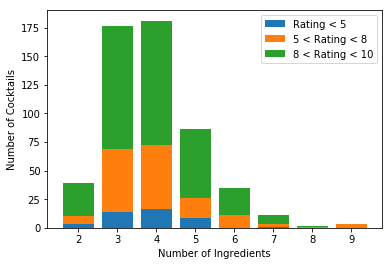

In [87]:
num_of_ingr = [ingr for ingr,count in num_sorted]

num_of_cockt_5 = [count[0] for ingr,count in num_sorted]
num_of_cockt_7 = [count[1] for ingr,count in num_sorted]
num_of_cockt_10 = [count[2] for ingr,count in num_sorted]


p1 = plt.bar(num_of_ingr, num_of_cockt_5, align='center')

p2 = plt.bar(num_of_ingr, num_of_cockt_7, bottom=num_of_cockt_5 , align='center')

p3 = plt.bar(num_of_ingr, num_of_cockt_10, bottom=num_of_cockt_7 , align='center')

plt.legend((p1,p2,p3),('Rating < 5','5 < Rating < 8 ','8 < Rating < 10'))

plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Cocktails')

plt.show()


In [88]:
receipe_df_rate.corr(method="pearson")

,Rating,Number of Votes,Number of Ingredients
Rating,1.000000,0.089054,0.031509
Number of Votes,0.089054,1.000000,0.006512
Number of Ingredients,0.031509,0.006512,1.000000


# <font color='blue'> Now we look at the original data frame </font>

In [89]:
## How many cocktails have a specific number of ingredients
num_dict = {}
for ingr_num in receipe_df['Number of Ingredients']:
    num_of_cockt = list(receipe_df['Number of Ingredients']).count(ingr_num)
    num_dict[ingr_num] = num_of_cockt 
    
num_sorted = sorted(num_dict.items(), key=lambda x: x[0])
num_sorted

[(2, 49), (3, 228), (4, 246), (5, 121), (6, 47), (7, 15), (8, 3), (9, 3)]

In [90]:
num_of_cockt = [count for ingr,count in num_sorted]
num_of_ingr = [ingr for ingr,count in num_sorted]

print(num_of_cockt)
print(num_of_ingr)

[49, 228, 246, 121, 47, 15, 3, 3]
[2, 3, 4, 5, 6, 7, 8, 9]


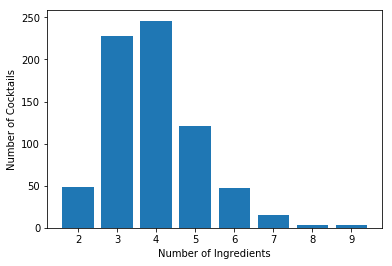

In [91]:
## plot number of cocktails vs number of ingredients

plt.bar(num_of_ingr, num_of_cockt, align='center')

plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Cocktails')

plt.show()


# <font color='blue'> Recommendation system for the original data frame </font>

In [92]:
###  Find the count matrix

count_vec = CountVectorizer() 
feature_vec = count_vec.fit_transform(receipe_df["Receipe"])


### generating the cosine similarity matrix

cos_sim = cosine_similarity(feature_vec, feature_vec)

cos_sim_df = pd.DataFrame(cos_sim )


### find the count vector 
vocab_vec = count_vec.fit(receipe_df["Receipe"])



In [93]:
cos_sim_df

,0,1,2,3,4,5,6,7,8,9,...,702,703,704,705,706,707,708,709,710,711
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117851,0.166667,...,0.129099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000
1,0.000000,1.000000,0.000000,0.169031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.169031,0.000000,1.000000,0.223607,0.000000,0.258199,0.000000,0.000000,0.258199,...,0.200000,0.316228,0.200000,0.000000,0.365148,0.258199,0.000000,0.258199,0.223607,0.000000
4,0.000000,0.000000,0.000000,0.223607,1.000000,0.000000,0.288675,0.288675,0.000000,0.000000,...,0.000000,0.353553,0.223607,0.000000,0.204124,0.288675,0.353553,0.000000,0.250000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.223607,0.000000
6,0.000000,0.000000,0.000000,0.258199,0.288675,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.408248,0.258199,0.000000,0.235702,0.333333,0.000000,0.000000,0.288675,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.288675,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.816497,0.000000,0.000000,0.000000
8,0.117851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.471405,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.235702,0.000000,0.000000
9,0.166667,0.000000,0.000000,0.258199,0.000000,0.000000,0.000000,0.000000,0.471405,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.235702,0.000000,0.000000,0.666667,0.000000,0.000000


In [94]:
vocab_vec.vocabulary_

{'redrum': 340,
 'rum': 350,
 '99bananas': 3,
 'bananaschnapps': 35,
 'strawberrydaiquirimix': 378,
 'sweetandsourmix': 388,
 'triplesec': 401,
 'powderedsugar': 326,
 'up': 403,
 'soda': 364,
 'icecream': 203,
 'whippedcream': 412,
 'sauza': 355,
 'hornitosreposadotequila': 198,
 'cointreau': 105,
 'orangeliqueur': 286,
 'mariebrizard': 259,
 'cremedefraisedesbois': 121,
 'limejuice': 237,
 '151proofrum': 0,
 'greygoose': 186,
 'vodka': 407,
 'wildturkey': 425,
 'bourbonwhiskey': 60,
 'gin': 167,
 'grandmarnier': 178,
 'lemonjuice': 226,
 'grenadinesyrup': 185,
 'orangebitters': 283,
 'oranges': 288,
 'cherry': 79,
 'deva': 134,
 'absinthe': 4,
 'benedictineherballiqueur': 41,
 'bitters': 45,
 'water': 409,
 'cherrycordial': 81,
 'limes': 239,
 'sweetvermouth': 390,
 'drysherry': 142,
 'apricotbrandy': 29,
 'lime': 235,
 'dryvermouth': 143,
 'amarettoalmondliqueur': 11,
 'bacardi': 32,
 'limonrum': 242,
 'cranberryjuice': 112,
 'yellowchartreuse': 427,
 'lemon': 224,
 'ice': 202,
 'wh

In [95]:
# build a list of ingredients and the # of times they have been used

freq_list = sorted([(ing, count) for ing,count in vocab_vec.vocabulary_.items()], key=lambda x:x[1], reverse=True)

In [96]:
### The most used ingredients (Top 10)
freq_list_df = pd.DataFrame(freq_list, columns=['Ingredient','Number of Uses'])
freq_list_df.iloc[0:10]

,Ingredient,Number of Uses
0,zubrowka,429
1,yoghurt,428
2,yellowchartreuse,427
3,worcestershiresauce,426
4,wildturkey,425
5,whitewine,424
6,whitetequila,423
7,whitesambuca,422
8,whiterum,421
9,whiteport,420


In [338]:
# the least used ingredients

freq_list_df.iloc[-10:]

,Ingredient,Number of Uses
420,alize,9
421,alcohol,8
422,aftershock,7
423,absolut,6
424,absintheherballiqueur,5
425,absinthe,4
426,99bananas,3
427,42below,2
428,151rum,1
429,151proofrum,0


In [97]:
## A function to show the common ingredients between two cocktails

def common_ingredients(coct1,coct2):
    index1  = receipe_df[receipe_df["Cocktail"]==coct1].index[0]
    index2  = receipe_df[receipe_df["Cocktail"]==coct2].index[0]
    
    receipe1 = receipe_df.iloc[index1]["Receipe"].split()
    receipe2 = receipe_df.iloc[index2]["Receipe"].split()
    
    common_ingr = []
    for ingredient in receipe1:
        if ingredient in receipe2:
            common_ingr.append(ingredient)
            
    return common_ingr

In [98]:
common_ingredients("Abbey","Bijou")

['gin', 'orangebitters', 'cherry']

In [100]:
###  Build a function that gives the n best matches to a chosen cocktail ###

def cocktail_recommender(cocktail_name):
    coct = cocktail_name
    ind  = receipe_df[receipe_df["Cocktail"]==coct].index[0]

    score = pd.Series(cos_sim_df[ind]).sort_values(ascending= False)

    ## ignore the score of the first index which is 1, corresponds to "coct" itself
    best_match_ind = list(score.iloc[1:6].index)



    ## add same scores as 5th cocktail in the list
    for i in range(5,712):
        if score.iloc[i+1]==score.iloc[i]:
            best_match_ind.append(list(score.iloc[i+1:i+2].index)[0])
        else:
            break
    
    
    ## make the list of at least top 5 matches     
    best_match=[]
    for i in best_match_ind:
        best_match.append(receipe_df.iloc[i][0])
        
    joint = ", "
    line = "-"*100
    print(f"If you are a fan of {coct}, you should also try {joint.join(best_match)}.\n{line}")
    
    coct_ing = receipe_df.iloc[ind]["Receipe"].split()
    print(f"{coct} Ingredients are: {coct_ing}")
    print("\n")
    
    for match in best_match:
        print(f"Common Ingredients with {match}: {common_ingredients(coct,match)}")
        print("_"*100)
        
    return print("Enjoy!")

An example:

In [101]:
cocktail_recommender("Margarita")

If you are a fan of Margarita, you should also try Margarita #5, McRita, Exorcist, Margarita #4, Jacqueline, Limey, Margarita #3, Margarita #2, Droog's Date.
----------------------------------------------------------------------------------------------------
Margarita Ingredients are: ['tequila', 'triplesec', 'limejuice']


Common Ingredients with Margarita #5: ['tequila', 'triplesec', 'limejuice']
____________________________________________________________________________________________________
Common Ingredients with McRita: ['tequila', 'triplesec']
____________________________________________________________________________________________________
Common Ingredients with Exorcist: ['tequila', 'limejuice']
____________________________________________________________________________________________________
Common Ingredients with Margarita #4: ['tequila', 'triplesec']
____________________________________________________________________________________________________
Common Ingredie

In [69]:
cocktail_recommender("Martini")

If you are a fan of Martini, you should also try Princeton, French Rose, Brown, Mint Gin, Parisian, Trinity, Wallick, Paris, Golf, Cuyahoga, HPW.
----------------------------------------------------------------------------------------------------
Martini Ingredients are: ['gin', 'dryvermouth']


Common Ingredients with Princeton: ['gin', 'dryvermouth']
____________________________________________________________________________________________________
Common Ingredients with French Rose: ['gin', 'dryvermouth']
____________________________________________________________________________________________________
Common Ingredients with Brown: ['gin', 'dryvermouth']
____________________________________________________________________________________________________
Common Ingredients with Mint Gin: ['gin', 'dryvermouth']
____________________________________________________________________________________________________
Common Ingredients with Parisian: ['gin', 'dryvermouth']
_____________

In [70]:
cocktail_recommender("Negroni")

If you are a fan of Negroni, you should also try Caricature, Perfect, Fernet Branca, Farmer's, Dry Negroni.
----------------------------------------------------------------------------------------------------
Negroni Ingredients are: ['gin', 'sweetvermouth', 'Campari®bitters']


Common Ingredients with Caricature: ['gin', 'sweetvermouth', 'Campari®bitters']
____________________________________________________________________________________________________
Common Ingredients with Perfect: ['gin', 'sweetvermouth']
____________________________________________________________________________________________________
Common Ingredients with Fernet Branca: ['gin', 'sweetvermouth']
____________________________________________________________________________________________________
Common Ingredients with Farmer's: ['gin', 'sweetvermouth']
____________________________________________________________________________________________________
Common Ingredients with Dry Negroni: ['gin', 'Campari®b